In [33]:
from pykrx import stock
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime


In [34]:
# Data Prerprocessing
samsung_code = "005930"    
skhynix_code = "000660"  

start_date = "2017-10-19"
end_date = "2019-10-31"

samsung_df = stock.get_market_ohlcv_by_date(start_date, end_date, samsung_code)
skhynix_df = stock.get_market_ohlcv_by_date(start_date, end_date, skhynix_code)


df = pd.DataFrame({'samsung': samsung_df['종가'], 'skhynix': skhynix_df['종가']}).astype(float)



In [35]:
# Monte Carlo Simulation
def monte_carlo_simulation(drift, volatility, epsilon, num_assets):
    dt_ = 1/247  # 일일 시간 간격
    log_returns = []
    for i in range(num_assets):
        log_return = (drift - 0.5 * volatility[i]**2) * dt_ + volatility[i] * np.sqrt(dt_) * epsilon[i]        
        log_returns.append(log_return)
    return np.array(log_returns)

# Worst Performer를 기준으로 ELS 가치평가
def find_f(worst_performer, index, rf, first, second, third, due_first, due_second, due_third, due_last, EC_strike_rate, first_payoff, second_payoff, third_payoff, f):
    initial_price = 10000
    if index < first and worst_performer[due_first] > EC_strike_rate:
            f.append(first_payoff*initial_price / np.exp(rf/247 * due_first))
    elif index < second and worst_performer[due_second] > EC_strike_rate:
        f.append(second_payoff*initial_price / np.exp(rf/247 * due_second))
    elif index < third and worst_performer[due_third] > EC_strike_rate:
        f.append(third_payoff*initial_price / np.exp(rf/247 * due_third))                  
    else:
        worst_mean = (worst_performer[due_last-2] + worst_performer[due_last-1] + worst_performer[due_last])/3
        max_return = max(worst_mean, 0.95)
        f.append(max_return*initial_price / np.exp(rf/247 * due_last))
    return


In [36]:
num_assets = 2
time_steps = 247
num_samples = 10000
rf = 0.02

df_index = df.iloc[252::5, :]
initial_price = df.iloc[252]
EC_strike_rate = 1.02
MC_strike_rate = 1.00
EC_strike_price = initial_price * EC_strike_rate
MC_strike_price = initial_price * MC_strike_rate
dt = 5/247
ELS_Delta1 = []
ELS_Delta2 = []

### 2018-10-31부터 5일단위로 rebalancing 진행
for index, names in df_index.iterrows():    
    print(index)
    simulated_S = []
    simulated_Su = []
    simulated_Sd = []
    
    # 리밸런싱 시점의 252 영업일 전부터의 데이터 가져오기
    init_price = df.loc[index]
    index_num = df.index.get_loc(index)    
    df_hist = df.iloc[index_num-252:index_num, :]    
        
    # MCMC로 10000개의 (2, 252) 누적 수익률 데이터 만들기
    cholesky_mat = np.linalg.cholesky(df_hist.corr())
    vol = np.log(df_hist/df_hist.shift(1))[1:].std() * np.sqrt(247)
        
    for _ in range(num_samples):                        
        epsilon = np.dot(cholesky_mat, np.random.randn(num_assets, time_steps))
        simulated_returns = monte_carlo_simulation(rf, vol, epsilon, num_assets)
        
        S = np.exp(np.cumsum((simulated_returns), axis=1))        
        S = np.insert(S, 0, 1.0, axis=1)[:, :-1]        
    
        Su = S.copy()
        Su[0] *= np.exp(vol[0]*np.sqrt(5*dt))
        Su[1] *= np.exp(vol[1]*np.sqrt(5*dt))
        Sd = S.copy()
        Sd[0] *= np.exp(-1*vol[0]*np.sqrt(5*dt))
        Sd[1] *= np.exp(-1*vol[1]*np.sqrt(5*dt))
        
        simulated_S.append(S)
        simulated_Su.append(Su)
        simulated_Sd.append(Sd)
                
    simulated_S = np.array(simulated_S)
    simulated_Su = np.array(simulated_Su)
    simulated_Sd = np.array(simulated_Sd)       
    
    # Correlation 고려하며 path가 생성되었는지 확인
    coef = []
    for a in simulated_S:
        coef.append(np.corrcoef(a)[0, 1])
    print("generated path의 correlation 평균 :", sum(coef)/len(simulated_S))
    print("historical path의 correlation :", df_hist.corr().iloc[0, 1])
    print(vol)
    print()
    
        
    ### ELS 가치평가
    first = datetime.strptime('2019-01-31', '%Y-%m-%d')
    second = datetime.strptime('2019-04-30', '%Y-%m-%d')
    third = datetime.strptime('2019-07-31', '%Y-%m-%d')
    last = datetime.strptime('2019-10-31', '%Y-%m-%d')
    
    f1_up = []
    f1_down = []
    f2_up = []
    f2_down = []
        
    first_payoff = 1.0159
    second_payoff = 1.0318
    third_payoff = 1.0477
        
    due_first = len(df.loc[:first]) - len(df.loc[:index])
    due_second = len(df.loc[:second]) - len(df.loc[:index])
    due_third = len(df.loc[:third]) - len(df.loc[:index])
    due_last = len(df.loc[:last]) - len(df.loc[:index])
        
    for S, Su, Sd in zip(simulated_S, simulated_Su, simulated_Sd):        
        
        # f1_up 구하기 : 기초자산1 상승, 기초자산2 불변        
        worst_performer = np.min(np.vstack((Su[0], S[1])), axis=0)        
        find_f(worst_performer, index, rf, first, second, third, due_first, due_second, due_third, due_last, EC_strike_rate, first_payoff, second_payoff, third_payoff, f1_up)        
        
        # f1_down 구하기 : 기초자산1 하락, 기초자산2 불변
        worst_performer = np.min(np.vstack((Sd[0], S[1])), axis=0)
        find_f(worst_performer, index, rf, first, second, third, due_first, due_second, due_third, due_last, EC_strike_rate, first_payoff, second_payoff, third_payoff, f1_down)        
                
        # f2_up 구하기 : 기초자산1 불변, 기초자산2 상승
        worst_performer = np.min(np.vstack((S[0], Su[1])), axis=0)
        find_f(worst_performer, index, rf, first, second, third, due_first, due_second, due_third, due_last, EC_strike_rate, first_payoff, second_payoff, third_payoff, f2_up)        
        
        # f2_down 구하기 : 기초자산1 불변, 기초자산2 하락
        worst_performer = np.min(np.vstack((S[0], Sd[1])), axis=0)
        find_f(worst_performer, index, rf, first, second, third, due_first, due_second, due_third, due_last, EC_strike_rate, first_payoff, second_payoff, third_payoff, f2_down)        
        
    # Els Delta 구하기    
    f1_up = sum(f1_up)/num_samples
    f1_down = sum(f1_down)/num_samples
    f2_up = sum(f2_up)/num_samples
    f2_down = sum(f2_down)/num_samples

    delta_1 = ((f1_up - f1_down)/10000) / ((init_price[0] * np.exp(vol[0]*np.sqrt(5*dt)) - init_price[0] * np.exp(-1*vol[0]*np.sqrt(5*dt))) / init_price[0])
    delta_2 = ((f2_up - f2_down)/10000) / ((init_price[1] * np.exp(vol[1]*np.sqrt(5*dt)) - init_price[1] * np.exp(-1*vol[1]*np.sqrt(5*dt))) / init_price[1])
    ELS_Delta1.append(delta_1)
    ELS_Delta2.append(delta_2)

2018-10-31 00:00:00
generated path의 correlation 평균 : 0.3854084148227838
historical path의 correlation : 0.4299169774400851
samsung    0.272033
skhynix    0.356072
dtype: float64
2018-11-07 00:00:00
generated path의 correlation 평균 : 0.4258693760826666
historical path의 correlation : 0.46530047179531936
samsung    0.274136
skhynix    0.355387
dtype: float64
2018-11-14 00:00:00
generated path의 correlation 평균 : 0.4448762602275732
historical path의 correlation : 0.4900367751267014
samsung    0.271029
skhynix    0.354786
dtype: float64
2018-11-21 00:00:00
generated path의 correlation 평균 : 0.4716355634260776
historical path의 correlation : 0.5194490184287702
samsung    0.271321
skhynix    0.357362
dtype: float64
2018-11-28 00:00:00
generated path의 correlation 평균 : 0.5139068585408458
historical path의 correlation : 0.5593067257173059
samsung    0.271809
skhynix    0.357963
dtype: float64
2018-12-05 00:00:00
generated path의 correlation 평균 : 0.5307053666018855
historical path의 correlation : 0.584938674

In [37]:
print("Asset 1\n", ELS_Delta1)
print("Asset 2\n", ELS_Delta2)

Asset 1
 [0.0904459125742103, 0.09160460900389149, 0.09734998394365083, 0.09980887849919946, 0.10012498356851565, 0.09942761413584106, 0.10669333007596547, 0.10914588844466691, 0.10877433042268575, 0.1129861879898901, 0.11849771793227032, 0.12956069954832755, 0.13204407975056337, 0.11450706542675775, 0.10986616783733516, 0.11544090330121465, 0.1177167236117888, 0.13297040035825128, 0.12660686796017007, 0.13629803039128918, 0.14183495887415457, 0.15172460874064062, 0.16909355206461685, 0.1688451601496542, 0.1790922400736234, 0.15195031788208674, 0.15892613297773925, 0.16101015869993487, 0.17752149079166468, 0.1800423750097315, 0.1842105227994842, 0.20354797545014688, 0.21846369772493943, 0.2259975558569945, 0.2520748706203881, 0.28404340786258037, 0.3154903111150329, 0.34514594385595115, 0.3368880687628552, 0.333735051880391, 0.33533265686473984, 0.33553309695291794, 0.33851219112026104, 0.3335852489333169, 0.332024052887265, 0.3430338125883198, 0.33769950398114945, 0.33517265940805807,

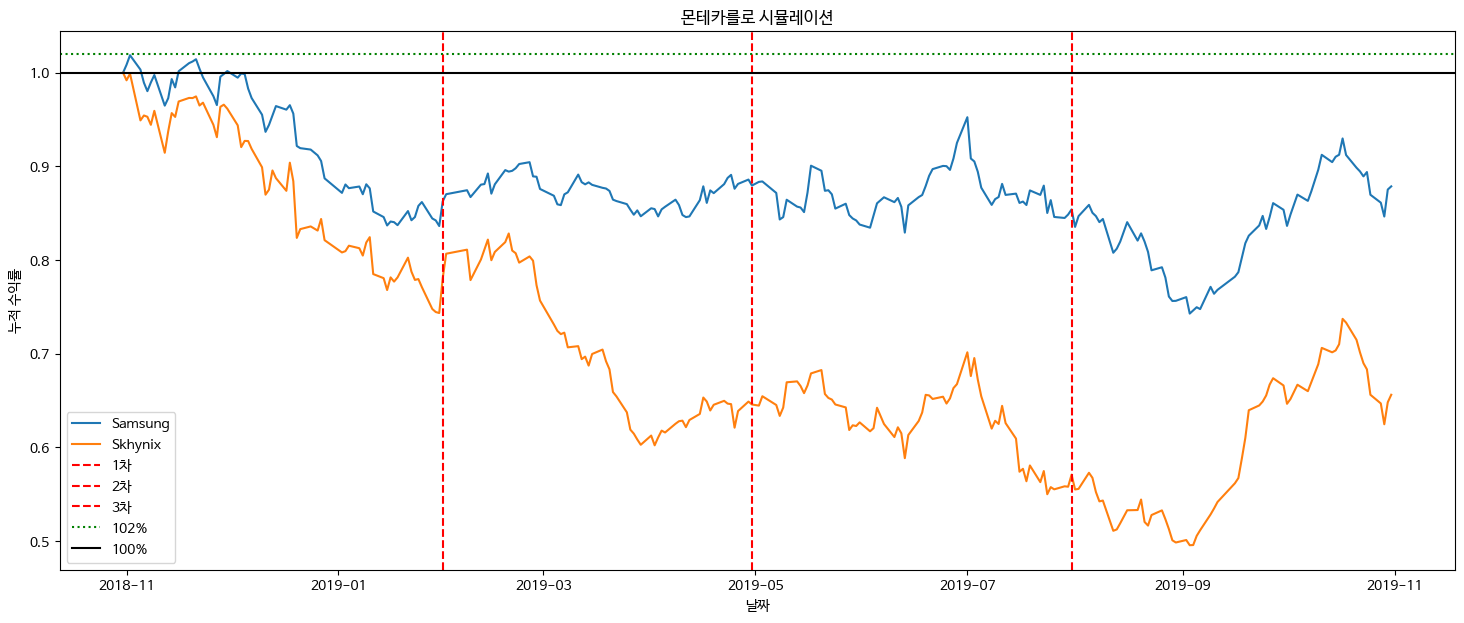

In [38]:
df_idx = df.iloc[252:, :]

# 결과 시각화
plt.figure(figsize=(18, 7))
plt.plot(df_idx.index, simulated_S[3, 0], label='Samsung')
plt.plot(df_idx.index, simulated_S[3, 1], label='Skhynix')
plt.title('몬테카를로 시뮬레이션')
plt.xlabel('날짜')
plt.ylabel('누적 수익률')

# 세로줄 추가
plt.axvline(first, color='red', linestyle='--', label='1차')
plt.axvline(second, color='red', linestyle='--', label='2차')
plt.axvline(third, color='red', linestyle='--', label='3차')

# 가로줄 추가
plt.axhline(y=1.02, color='green', linestyle=':', label='102%')
plt.axhline(y=1.00, color='black', linestyle='-', label='100%')

plt.legend()
plt.show()


/tmp/ipykernel_3702876/1448296033.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_idx['samsung_cumulative_returns'] = (df_idx['samsung'] / df_idx['samsung'].iloc[0]).cumprod()
/tmp/ipykernel_3702876/1448296033.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_idx['skynix_cumulative_returns'] = (df_idx['skhynix'] / df_idx['skhynix'].iloc[0]).cumprod()


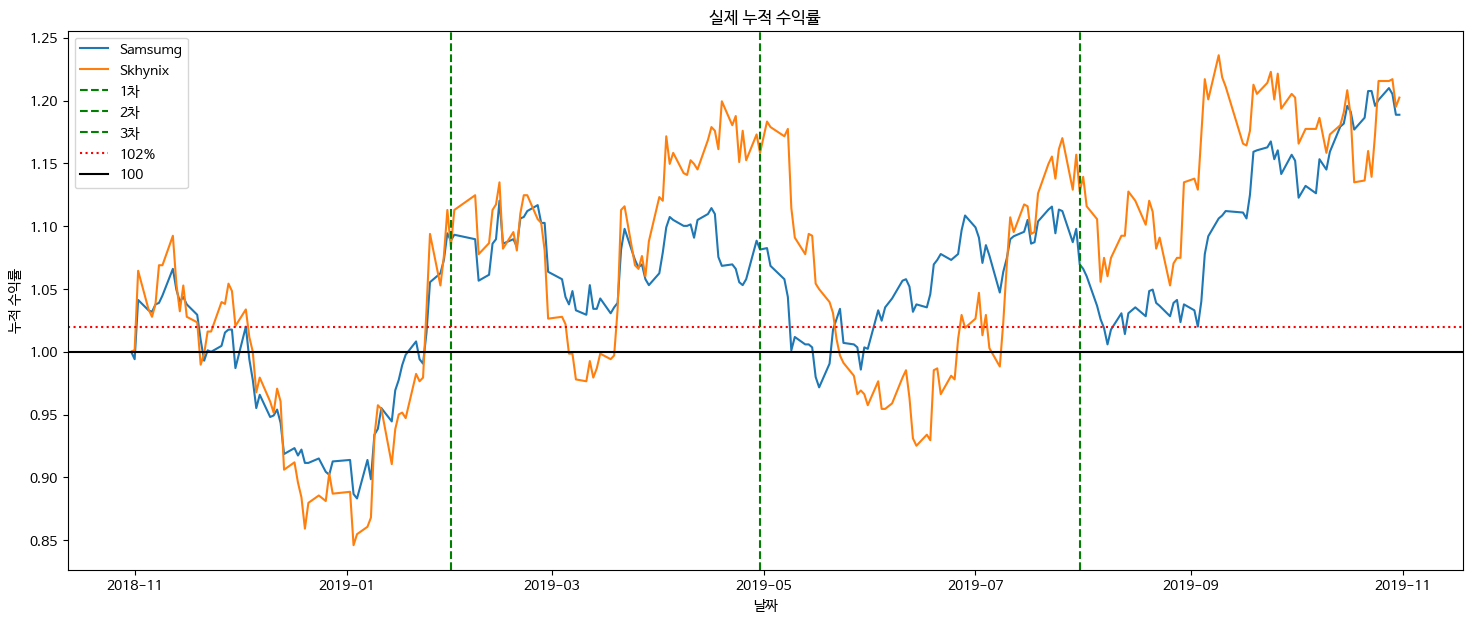

In [39]:

df_idx['samsung_cumulative_returns'] = (df_idx['samsung'] / df_idx['samsung'].iloc[0]).cumprod()
df_idx['skynix_cumulative_returns'] = (df_idx['skhynix'] / df_idx['skhynix'].iloc[0]).cumprod()

# 결과 시각화
plt.figure(figsize=(18, 7))
plt.plot(df_idx.index, df_idx['samsung_cumulative_returns'].pct_change().fillna(0) + 1.0, label='Samsumg')
plt.plot(df_idx.index, df_idx['skynix_cumulative_returns'].pct_change().fillna(0) + 1.0, label='Skhynix')
plt.title('실제 누적 수익률')
plt.xlabel('날짜')
plt.ylabel('누적 수익률')

# 세로줄 추가 (예: x=50일 때)
plt.axvline(first, color='green', linestyle='--', label='1차')
plt.axvline(second, color='green', linestyle='--', label='2차')
plt.axvline(third, color='green', linestyle='--', label='3차')

# 가로줄 추가 (예: y=0.2일 때)
plt.axhline(y=1.02, color='red', linestyle=':', label='102%')
plt.axhline(y=1.00, color='black', linestyle='-', label='100')

plt.legend()
plt.show()